# Gamergate scandal - analysis of tweets 
All tweets contain #gamergate hashtag and was collected using twint tool.
Data come from the first month after the given hashtag was used for the first time.

## Load data

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import pandas as pd
import json

In [0]:
filename = 'gamergate.json'
with open('/content/gdrive/My Drive/' + filename, 'r', encoding="utf8") as file:
  u_ids, u_names, msgs, mentions = [], [], [], []
  for line in file:
        try:
            tweet = json.loads(line)
            u_ids.append(tweet['user_id'])
            u_names.append(tweet['username'])
            msgs.append(tweet['tweet'])
            
            mentions_list = tweet['mentions']
            splitted = mentions_list.split(sep=',')
            mentions.append(splitted[0])
            
            # if more than one user was mentioned add duplicated row with new mentioned user
            if len(splitted) > 1:
                for i in range(1, len(splitted)): 
                    mentions.append(splitted[i])
                    u_ids.append(tweet['user_id'])
                    u_names.append(tweet['username'])
                    msgs.append(tweet['tweet'])
        except:
            continue
  tweets_df = pd.DataFrame([u_ids,u_names,msgs,mentions]).T 
  tweets_df.columns = ['user_id','user_name','text', 'mentioned_name']

In [0]:
print('tweets number: ', len(tweets_df))
tweets_df.head()

tweets number:  118533


,user_id,user_name,text,mentioned_name
0,2257351506,blackwing882,#GamerGate #notyourshield hmm i game and im a...,
1,74195443,mulletalchemist,@PixieJenni If you don't see how your own prej...,pixiejenni
2,15384197,fluffypira,"@Content4Freedom @muffinista Oh yeah, that's r...",content4freedom
3,15384197,fluffypira,"@Content4Freedom @muffinista Oh yeah, that's r...",muffinista
4,2796576235,note_pad_exe,@SambledEggs an example of the anti-#GamerGate...,sambledeggs


## Create network from users mentioned in tweets

In [0]:
import networkx as nx
import matplotlib.pyplot as plt

In [0]:
def get_edges_for_graph(df, source, target):
    edges = []
    for _, row in df.iterrows():
        if row[target] != '':
            edges.append((row[source], row[target]))
     
    return edges

In [0]:
G = nx.Graph()
edges = get_edges_for_graph(tweets_df, 'user_name', 'mentioned_name')
G.add_edges_from(edges)

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 13262
Number of edges: 37974
Average degree:   5.7267


In [0]:
nx.draw_spring(G, node_size=20)

## Community detection on obtained network

In [0]:
!pip install python-louvain

In [0]:
def get_communities(G):
    import community as community
    
    communities_dict = community.best_partition(G)
    communities_df = pd.DataFrame(list(communities_dict.items()), columns=['username', 'community'])
    
    return communities_df

In [0]:
communities_df = get_communities(G)
print('number of users: ', len(communities_df))
communities_df.head()

number of users:  13262


,username,community
0,mulletalchemist,0
1,pixiejenni,0
2,fluffypira,1
3,content4freedom,0
4,muffinista,1


In [0]:
print('number of communities: ', len(communities_df['community'].value_counts()))

number of communities:  699


In [0]:
def get_top_n_communities(communities, community_column_name='community', n=10):
    communities_ids = communities[community_column_name].value_counts().head(n=n).reset_index()['index']
    
    return communities[communities[community_column_name].isin(communities_ids)]

In [0]:
def get_top_communities_summary(communities, community_column_name='community', n=10):
    top_communities = get_top_n_communities(communities, community_column_name, n)
    
    communities_size = []
    for id, group in top_communities.groupby(community_column_name):
        communities_size.append((id,len(group)))
    
    return pd.DataFrame(communities_size, columns=['community_id', 'community_size']).sort_values(by=['community_size'], ascending=False)

In [0]:
communities_size = get_top_communities_summary(communities_df, 'community', 20)
print('communities number: ', len(communities_size))
communities_size

communities number:  20


,community_id,community_size
4,4,1801
0,0,877
3,3,805
9,9,771
2,2,716
7,7,699
18,24,531
6,6,512
17,21,474
16,18,427


In [0]:
def draw_communities(G, communities_df):    
    nodes = list(communities_df.to_dict()['username'].values())
    colors = list(communities_df.to_dict()['community'].values())
    
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=colors, 
                            with_labels=False, node_size=50, cmap=plt.cm.jet)
    nx.draw_networkx_edges(G, pos, alpha=0.2)

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


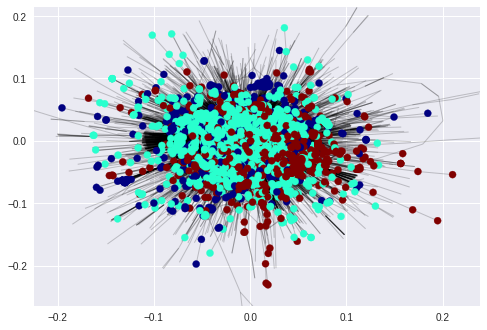

In [0]:
top_communities = get_top_n_communities(communities_df, 'community', 3)
draw_communities(G, top_communities)

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


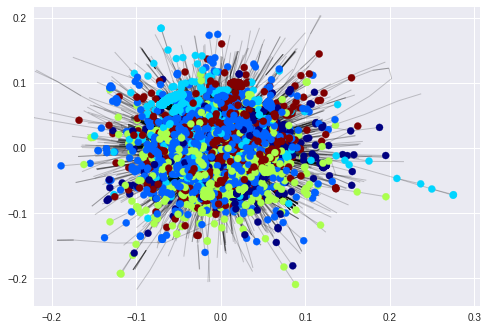

In [0]:
top_communities = get_top_n_communities(communities_df, 'community', 5)
draw_communities(G, top_communities)

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


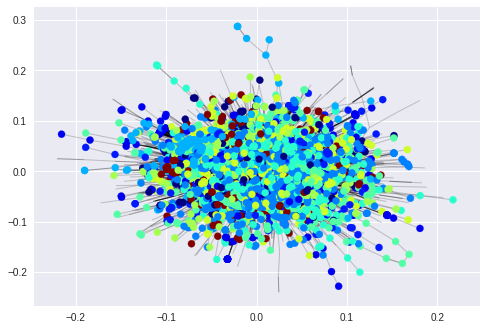

In [0]:
top_communities = get_top_n_communities(communities_df, 'community', 10)
draw_communities(G, top_communities)

## Community Analysis

### Prepare data

In [0]:
filename = 'gamergate.json'
with open('/content/gdrive/My Drive/' + filename, 'r', encoding="utf8") as file:
  u_ids, u_names, msgs, mentions = [], [], [], []
  for line in file:
        try:
            tweet = json.loads(line)
            u_ids.append(tweet['user_id'])
            u_names.append(tweet['username'])
            msgs.append(" ".join(tweet['tweet'].split()))
            mentions.append(tweet['mentions'])
        except:
            continue
  tweets = pd.DataFrame([u_ids,u_names,msgs,mentions]).T 
  tweets.columns = ['user_id','user_name','text', 'mentioned_name']

In [0]:
tweets.head()

,user_id,user_name,text,mentioned_name
0,2257351506,blackwing882,#GamerGate #notyourshield hmm i game and im a ...,
1,74195443,mulletalchemist,@PixieJenni If you don't see how your own prej...,pixiejenni
2,15384197,fluffypira,"@Content4Freedom @muffinista Oh yeah, that's r...","content4freedom,muffinista"
3,2796576235,note_pad_exe,@SambledEggs an example of the anti-#GamerGate...,sambledeggs
4,322463395,allanschumacher,@WolfFury26 @acesrhigh @Dylof_ @Mal_com_U I ha...,"wolffury26,acesrhigh,mal_com_u"


In [0]:
def get_cleared_text(text):
    import re
    
    #remove emoji
    emoji_pattern = re.compile("["
          u"\U0001F600-\U0001F64F"  # emoticons
          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
          u"\U0001F680-\U0001F6FF"  # transport & map symbols
          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                             "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
  
    # remove mentions
    mention_pattern = re.compile("@[a-zA-z0-9]+", flags=re.UNICODE)
    text = mention_pattern.sub(r'', text)
    
    # remove hashtags
    mention_pattern = re.compile("#[a-zA-z0-9]+", flags=re.UNICODE)
    text = mention_pattern.sub(r'', text)
    
    #remove links
    text = re.sub(r"http\S+", "", text)
    
    return re.sub('\s+', ' ', text)

In [0]:
for i in range(10):
  print('#', i, '\n\tbefor: ', tweets_df.text[i], '\n\tafter: ', get_cleared_text(tweets_df.text[i]))

# 0 
	befor:  #GamerGate #notyourshield  hmm i game and im a mecha  aka transfan loves transformers 
	after:   hmm i game and im a mecha aka transfan loves transformers
# 1 
	befor:  @PixieJenni If you don't see how your own prejudices might blind you to a good cause like it might have your grandparents? Wow #GamerGate 
	after:   If you don't see how your own prejudices might blind you to a good cause like it might have your grandparents? Wow 
# 2 
	befor:  @Content4Freedom @muffinista Oh yeah, that's right. You're trying to prove that #GamerGate isn't misogynistic by invading my mentions. 
	after:   Oh yeah, that's right. You're trying to prove that isn't misogynistic by invading my mentions.
# 3 
	befor:  @Content4Freedom @muffinista Oh yeah, that's right. You're trying to prove that #GamerGate isn't misogynistic by invading my mentions. 
	after:   Oh yeah, that's right. You're trying to prove that isn't misogynistic by invading my mentions.
# 4 
	befor:  @SambledEggs an example of t

In [0]:
def count_mentions(list_of_mentions, split_char=','):
  result = 0
  splitted = list_of_mentions.split(split_char)
  if len(splitted) == 1:
    if splitted[0]=='':
      result = 0
    else:
      result = 1
  else:
    result = len(splitted)
  
  return result    

In [0]:
!pip install textblob

In [0]:
import textblob
from textblob import TextBlob

In [0]:
def get_text_sentiment(text):
    try:
        polarity = TextBlob(text).sentiment.polarity
    except ZeroDivisionError:
        polarity = 0

    return polarity

In [0]:
tweets['hashtags_number'] = [text.count('#') for text in tweets.text]
tweets['mentions_number'] = [count_mentions(m) for m in tweets.mentioned_name]
tweets.text = [get_cleared_text(text) for text in tweets.text]
tweets['text_length'] = [len(" ".join(text.split())) for text in tweets.text]

In [0]:
tweets['text_sentiment'] = [get_text_sentiment(text) for text in tweets.text]

In [0]:
tweets.head()

,user_id,user_name,text,mentioned_name,hashtags_number,mentions_number,text_length,text_sentiment
0,2257351506,blackwing882,hmm i game and im a mecha aka transfan loves ...,,2,0,57,-0.400000
1,74195443,mulletalchemist,If you don't see how your own prejudices migh...,pixiejenni,1,1,114,0.225000
2,15384197,fluffypira,"Oh yeah, that's right. You're trying to prove...","content4freedom,muffinista",1,2,94,0.285714
3,2796576235,note_pad_exe,an example of the anti- crowd everybody!,sambledeggs,1,1,40,0.000000
4,322463395,allanschumacher,I have a long talk with someone about and her...,"wolffury26,acesrhigh,mal_com_u",2,3,49,-0.050000


In [0]:
groupedbyuser = tweets.groupby('user_name').mean()

In [0]:
groupedbyuser.head()

,hashtags_number,mentions_number,text_length,text_sentiment
user_name,,,,
007bistromath,1.625,0.625,65.0,0.038281
007jacquie,1.000,1.000,40.0,0.066071
00looper00,1.000,2.000,55.5,0.000000
01stewartn,1.000,0.000,82.0,-0.077778
0_kelvin,1.000,0.000,12.0,0.000000


In [0]:
communities_df.columns=['user_name', 'community']
communities_df.head()


,user_name,community
0,mulletalchemist,0
1,pixiejenni,0
2,fluffypira,1
3,content4freedom,0
4,muffinista,1


In [0]:
groupedbyuser['user_name'] = [name for name in groupedbyuser.index]

In [0]:
result = pd.merge(communities_df, groupedbyuser, on='user_name', how='left')
result.dropna(inplace=True)
result.head()

,user_name,community,hashtags_number,mentions_number,text_length,text_sentiment
0,mulletalchemist,0,1.230769,0.871795,88.410256,0.053241
2,fluffypira,1,1.132450,0.370861,81.410596,-0.025221
4,muffinista,1,1.000000,0.000000,30.000000,0.000000
5,note_pad_exe,2,1.166667,1.000000,74.000000,-0.042361
7,allanschumacher,2,1.571429,1.428571,81.571429,0.042857


### Classification

In [0]:
from sklearn import svm

In [0]:
top_communities = get_top_n_communities(result, 'community', 10)
x = np.array(top_communities[['hashtags_number', 'mentions_number', 'text_length', 'text_sentiment']].values.tolist())
y = np.array(top_communities[['community']].values.tolist()).flatten()
train_x, test_x = np.split(x, [int(.9*len(x))])
train_y, test_y = np.split(y, [int(.9*len(y))])

clf = svm.SVC()
clf = clf.fit(train_x, train_y)
predicted = clf.predict(test_x)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [0]:
import sklearn.metrics as metrics

print('accuracy:', metrics.accuracy_score(test_y, predicted))
print('f1:', metrics.f1_score(test_y, predicted, average='macro'))

accuracy: 0.24649298597194388
f1: 0.07868567027869858


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
def draw_confusiom_matrix(y_true, y_pred):
    import seaborn as sns
    import sklearn.metrics as metrics

    plt.figure(figsize=(10, 10))
    sns.heatmap(metrics.confusion_matrix(y_true, y_pred), annot=True)

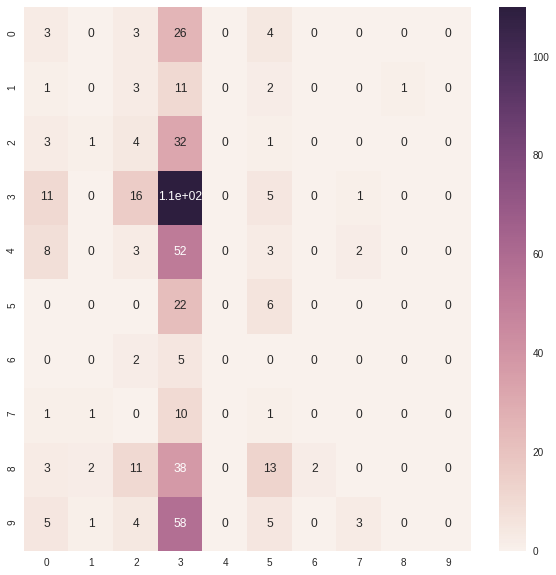

In [0]:
draw_confusiom_matrix(test_y, predicted)

In [0]:
print('Class distribution')
top_communities['community'].value_counts()

Class distribution


4     1119
3      603
7      601
0      533
9      472
2      418
8      320
24     315
21     307
6      300
Name: community, dtype: int64